# Creating features and target

## import packages and DataFrame

In [1]:
from features import Dataframe
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from functools import reduce
from utils import Utils
import warnings
warnings.filterwarnings('ignore')

In [2]:
polkadot = Dataframe().get_dataframe()

In [3]:
polkadot.tail(10)

,date,current_price,current_price_sats,market_cap,reddit_post_48h,reddit_comment_48h,reddit_subscribers,reddit_active_accounts,public_interest_stats,Value,Value_classification,new_accounts,active_accounts,fees
628,2022-05-09,13.229361,38851.622851,1.469313e+10,0.600,5.100,39889.0,60.363636,38454.0,11.0,Extreme Fear,4074.0,3933.0,15520.0
629,2022-05-10,10.801430,35649.269219,1.205226e+10,2.000,16.556,39906.0,70.600000,38454.0,10.0,Extreme Fear,3867.0,4157.0,18061.0
630,2022-05-11,11.325015,36527.298076,1.252311e+10,0.917,11.500,39925.0,78.923077,38454.0,12.0,Extreme Fear,5667.0,6260.0,23805.0
631,2022-05-12,8.901204,30831.159321,9.740921e+09,0.750,15.250,39948.0,81.000000,38454.0,12.0,Extreme Fear,6475.0,5720.0,22966.0
632,2022-05-13,8.769325,30114.350218,9.672795e+09,1.222,12.778,39965.0,78.900000,38454.0,10.0,Extreme Fear,4667.0,4158.0,17438.0
633,2022-05-14,10.487976,35798.763057,1.154770e+10,1.444,15.333,39974.0,73.600000,38454.0,9.0,Extreme Fear,3449.0,6027.0,14147.0
634,2022-05-15,11.376092,37684.247686,1.273195e+10,1.250,15.250,39986.0,57.555556,38454.0,10.0,Extreme Fear,2881.0,11712.0,18628.0
635,2022-05-16,11.800641,37710.067770,1.308825e+10,1.222,19.000,39992.0,60.300000,51803.0,14.0,Extreme Fear,821.0,4677.0,7225.0
636,2022-05-17,10.661735,35619.793504,1.187424e+10,1.200,8.600,40003.0,64.363636,51803.0,8.0,Extreme Fear,NaN,NaN,NaN
637,2022-05-18,11.053819,36248.812004,1.231961e+10,1.167,9.917,40019.0,66.153846,51803.0,12.0,Extreme Fear,NaN,NaN,NaN


## create target

> create price in 14 days as target, then convert that into 0 (price less than the day before)
or 1 (price more than the day before)

In [4]:
polkadot['predict'] = polkadot['current_price'].shift(-14)

In [5]:
polkadot['predict'] = pd.Series(np.where(polkadot['predict'].values < polkadot['current_price'], 0, 1),
          polkadot.index)

#### create final test set to predict future prices

In [6]:
polkadot_final_test = polkadot.iloc[-14:, :].drop(columns='predict')

In [7]:
polkadot_final_test.tail()

,date,current_price,current_price_sats,market_cap,reddit_post_48h,reddit_comment_48h,reddit_subscribers,reddit_active_accounts,public_interest_stats,Value,Value_classification,new_accounts,active_accounts,fees
633,2022-05-14,10.487976,35798.763057,1.154770e+10,1.444,15.333,39974.0,73.600000,38454.0,9.0,Extreme Fear,3449.0,6027.0,14147.0
634,2022-05-15,11.376092,37684.247686,1.273195e+10,1.250,15.250,39986.0,57.555556,38454.0,10.0,Extreme Fear,2881.0,11712.0,18628.0
635,2022-05-16,11.800641,37710.067770,1.308825e+10,1.222,19.000,39992.0,60.300000,51803.0,14.0,Extreme Fear,821.0,4677.0,7225.0
636,2022-05-17,10.661735,35619.793504,1.187424e+10,1.200,8.600,40003.0,64.363636,51803.0,8.0,Extreme Fear,NaN,NaN,NaN
637,2022-05-18,11.053819,36248.812004,1.231961e+10,1.167,9.917,40019.0,66.153846,51803.0,12.0,Extreme Fear,NaN,NaN,NaN


#### drop last fourteen rows from DataFrame

> drop three rows taken from on-chain data, as they were not originally included for this section

In [8]:
polkadot.drop(polkadot.index[-14:], inplace=True)

In [9]:
X_orig = polkadot.drop(columns=['predict', 'date', 'Value_classification',
                                'new_accounts', 'active_accounts', 'fees'])
y_orig = polkadot['predict']

#### test score with original features

In [10]:
classifiers_original = Utils().test_classifiers(X_orig, y_orig)

In [11]:
classifiers_original

,scores
KNeighbors,0.761677
Support Vector,0.757616
Decision Tree,0.819495
Random Forest,0.869717
Ada Boost,0.831636
Gradient Boost,0.855636


## create new features

In [12]:
polkadot['price_ema5'] = polkadot['current_price'].ewm(span=5, adjust=False).mean()
polkadot['price_ema20'] = polkadot['current_price'].ewm(span=20, adjust=False).mean()
polkadot['price_ema50'] = polkadot['current_price'].ewm(span=50, adjust=False).mean()

polkadot['fear_ema5'] = polkadot['Value'].ewm(span=2, adjust=False).mean()
polkadot['fear_ema20'] = polkadot['Value'].ewm(span=20, adjust=False).mean()
polkadot['fear_ema50'] = polkadot['Value'].ewm(span=50, adjust=False).mean()

polkadot['fear_change_2_days'] = polkadot['Value'] - polkadot['Value'].shift(2)
polkadot['fear_change_1_week'] = polkadot['Value'] - polkadot['Value'].shift(7)
polkadot['fear_change_2_weeks'] = polkadot['Value'] - polkadot['Value'].shift(14)

polkadot['reddit_post_ema5'] = polkadot['reddit_post_48h'].ewm(span=5, adjust=False).mean()
polkadot['reddit_post_ema20'] = polkadot['reddit_post_48h'].ewm(span=20, adjust=False).mean()
polkadot['reddit_post_ema50'] = polkadot['reddit_post_48h'].ewm(span=50, adjust=False).mean()

polkadot['reddit_change_2_days'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(2)
polkadot['reddit_change_1_week'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(7)
polkadot['reddit_change_2_weeks'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(14)

polkadot['sats_ema5'] = polkadot['current_price_sats'].ewm(span=5, adjust=False).mean()
polkadot['sats_ema20'] = polkadot['current_price_sats'].ewm(span=20, adjust=False).mean()
polkadot['sats_ema50'] = polkadot['current_price_sats'].ewm(span=50, adjust=False).mean()

polkadot['sats_change_2_days'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(2)
polkadot['sats_change_1_week'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(7)
polkadot['sats_change_2_weeks'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(14)

polkadot['price_change_2_days'] = polkadot['current_price'] - polkadot['current_price'].shift(2)
polkadot['price_change_1_week'] = polkadot['current_price'] - polkadot['current_price'].shift(7)
polkadot['price_change_2_weeks'] = polkadot['current_price'] - polkadot['current_price'].shift(14)

In [13]:
polkadot['percent_change_2_days'] = polkadot['current_price'].pct_change(periods=2)
polkadot['percent_change_1_week'] = polkadot['current_price'].pct_change(periods=7)
polkadot['percent_change_2_weeks'] = polkadot['current_price'].pct_change(periods=14)

In [14]:
polkadot['percent_sats_2_days'] = polkadot['current_price_sats'].pct_change(periods=2)
polkadot['percent_sats_1_week'] = polkadot['current_price_sats'].pct_change(periods=7)
polkadot['percent_sats_2_weeks'] = polkadot['current_price_sats'].pct_change(periods=14)

In [15]:
df = Dataframe().get_features(forecast_out=14)

## find features and model

### create features and target

> drop three rows taken from on-chain data, as they were not originally included for this section

In [16]:
df = df.drop(columns=['new_accounts', 'active_accounts', 'fees'])

In [17]:
X = df.drop(columns=['predict', 'date', 'Value_classification'])
y = df['predict']

### test different classifiers

> Create training set, validation set, and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### use RobustScaler to scale features

In [19]:
scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
imp_simple = SimpleImputer()
imp_simple.fit(X_train)
X_train_scaled = imp_simple.transform(X_train)
X_test_scaled = imp_simple.transform(X_test)

### create function to test different out of the box models on the data set

In [21]:
k_regressor = KNeighborsClassifier()
s_model = SVC(random_state=42)
classifier = DecisionTreeClassifier(random_state=42)
random_classifier = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
gradient = GradientBoostingClassifier(random_state=42)

In [22]:
score_k = cross_val_score(k_regressor, X_train_scaled, y_train, cv=5)
score_s = cross_val_score(s_model, X_train_scaled, y_train, cv=5)
score_c = cross_val_score(classifier, X_train_scaled, y_train, cv=5)
score_rc = cross_val_score(random_classifier, X_train_scaled, y_train, cv=5)
score_a = cross_val_score(ada, X_train_scaled, y_train, cv=5)
score_g = cross_val_score(gradient, X_train_scaled, y_train, cv=5)


In [23]:
scores = pd.DataFrame(columns=['scores'], index=['KNeighbors', 'Support Vector', 'Decision Tree',
                                                'Random Forest', 'Ada Boost', 'Gradient Boost'], 
                      data=[score_k.mean(), score_s.mean(), score_c.mean(), score_rc.mean(),
                           score_a.mean(), score_g.mean()])

In [24]:
scores

,scores
KNeighbors,0.605152
Support Vector,0.593253
Decision Tree,0.767394
Random Forest,0.891758
Ada Boost,0.839576
Gradient Boost,0.893818


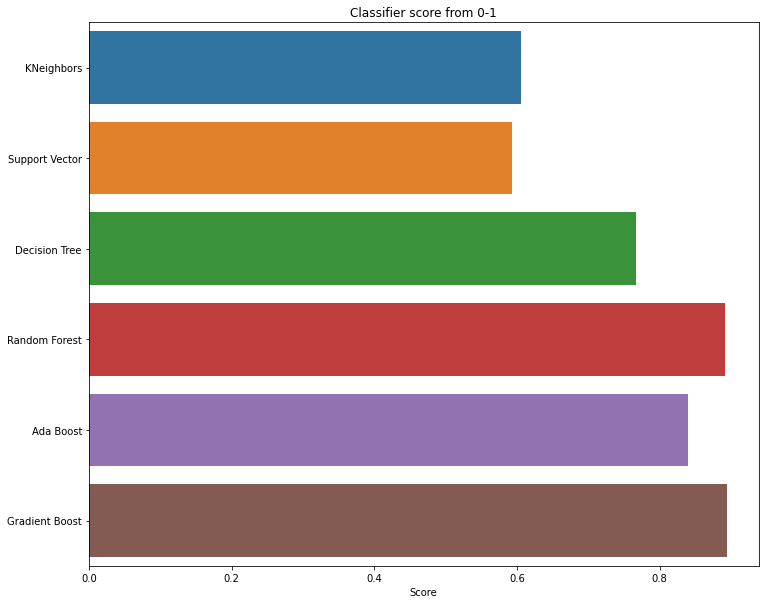

In [25]:
plt.figure(figsize=(12,10))
sns.barplot(y=scores.index, x=scores['scores'])
plt.xlabel('Score')
plt.title('Classifier score from 0-1');

In [26]:
classifiers = Utils().test_classifiers(X, y)

In [27]:
classifiers

,scores
KNeighbors,0.703374
Support Vector,0.707333
Decision Tree,0.769394
Random Forest,0.891758
Ada Boost,0.839576
Gradient Boost,0.893818


> Let's experiment more with RandomForestClassifier to see if we can improve results

# Remove features and test performance

> remove variables with high correlation

In [28]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

                        current_price  current_price_sats  market_cap  \
current_price                     NaN            0.908462    0.996690   
current_price_sats                NaN                 NaN    0.900876   
market_cap                        NaN                 NaN         NaN   
reddit_post_48h                   NaN                 NaN         NaN   
reddit_comment_48h                NaN                 NaN         NaN   
reddit_subscribers                NaN                 NaN         NaN   
reddit_active_accounts            NaN                 NaN         NaN   
public_interest_stats             NaN                 NaN         NaN   
Value                             NaN                 NaN         NaN   
price_ema5                        NaN                 NaN         NaN   
price_ema20                       NaN                 NaN         NaN   
price_ema50                       NaN                 NaN         NaN   
fear_ema5                         NaN              

In [29]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)


['market_cap', 'price_ema5', 'price_ema20', 'price_ema50', 'fear_ema5', 'fear_ema50', 'sats_ema5', 'sats_ema20', 'sats_ema50']


In [30]:
X_reduced = X.drop(columns=to_drop, axis=1)
X_reduced.head()

,current_price,current_price_sats,reddit_post_48h,reddit_comment_48h,reddit_subscribers,reddit_active_accounts,public_interest_stats,Value,fear_ema20,fear_change_2_days,...,sats_change_2_weeks,price_change_2_days,price_change_1_week,price_change_2_weeks,percent_change_2_days,percent_change_1_week,percent_change_2_weeks,percent_sats_2_days,percent_sats_1_week,percent_sats_2_weeks
0,2.936665,25024.566687,0.000,0.750,193.0,7.200000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.936665,25024.566687,0.000,0.667,212.0,5.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.898791,24435.409268,0.000,1.727,237.0,6.333333,NaN,NaN,NaN,NaN,...,NaN,-0.037874,NaN,NaN,-0.012897,NaN,NaN,-0.023543,NaN,NaN
3,2.871923,24934.417517,0.417,2.750,269.0,8.538462,NaN,NaN,NaN,NaN,...,NaN,-0.064742,NaN,NaN,-0.022046,NaN,NaN,-0.003602,NaN,NaN
4,4.481389,38367.856477,1.091,5.364,313.0,16.500000,NaN,NaN,NaN,NaN,...,NaN,1.582598,NaN,NaN,0.545951,NaN,NaN,0.570174,NaN,NaN


### use test classifiers function to compare X_reduced with X

In [31]:
classifiers_reduced = Utils().test_classifiers(X_reduced, y)

In [32]:
classifiers

,scores
KNeighbors,0.703374
Support Vector,0.707333
Decision Tree,0.769394
Random Forest,0.891758
Ada Boost,0.839576
Gradient Boost,0.893818


In [33]:
classifiers_reduced

,scores
KNeighbors,0.665293
Support Vector,0.687333
Decision Tree,0.773515
Random Forest,0.869657
Ada Boost,0.825556
Gradient Boost,0.857697


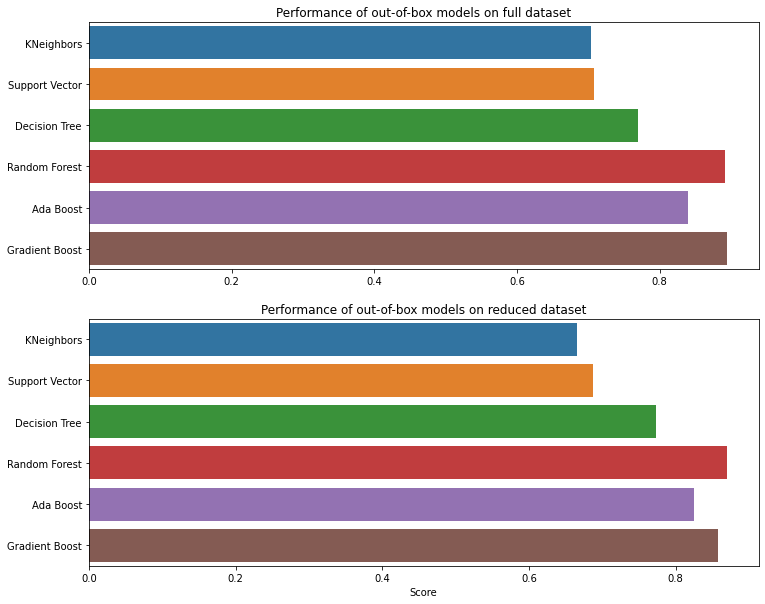

In [34]:
fix, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
sns.barplot(y=classifiers.index, x=classifiers['scores'], ax=ax1)
sns.barplot(y=classifiers_reduced.index, x=classifiers_reduced['scores'], ax=ax2)
ax1.set_xlabel('')
ax2.set_xlabel('Score')
ax1.set_title('Performance of out-of-box models on full dataset')
ax2.set_title('Performance of out-of-box models on reduced dataset');

> reducing highly correlated from the dataset decreases the score on the validation set.

# Add features and test performance

In [35]:
on_chain = Dataframe().get_on_chain()

In [36]:
on_chain['fees_per_account'] = on_chain['fees']/on_chain['active_accounts']
on_chain.drop(columns='date', inplace=True)

In [37]:
X_new = X_reduced.merge(on_chain, left_index=True, right_index=True, how='left')

In [38]:
classifiers_added = Utils().test_classifiers(X_new, y)

In [39]:
classifiers_added

,scores
KNeighbors,0.733394
Support Vector,0.731434
Decision Tree,0.777475
Random Forest,0.861677
Ada Boost,0.839535
Gradient Boost,0.859717


### write function to remove features until the best score is found

In [40]:
df2 = Dataframe().get_features(forecast_out=14)

In [41]:
X = df.drop(columns=['predict', 'date', 'Value_classification'])
y = df['predict']

In [42]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.2, random_state=42)

imp_simple = SimpleImputer()
imp_simple.fit(X_train_new)
X_train_new_impute = imp_simple.transform(X_train_new)
X_test_new_impute = imp_simple.transform(X_test_new)

scaler = RobustScaler().fit(X_train_new_impute)
X_train_new_scaled = scaler.transform(X_train_new_impute)
X_test_new_scaled = scaler.transform(X_test_new_impute)

In [43]:
def find_best_features_gradient(X, y):
    score = list()
    k_record = list()
    for i in range(1, X.shape[1]):
        select_features = SelectKBest(score_func=mutual_info_classif, k=i)
        select_features.fit(X, y)
        X_reduced = select_features.transform(X)
        gradient = GradientBoostingClassifier(random_state=42)
        s = cross_val_score(gradient, X_reduced, y, cv=5).mean()
        score.append(s)
        k_record.append(i)
    return k_record, score

In [44]:
k, score = find_best_features_gradient(X_train_new_scaled, y_train_new)

In [45]:
def find_best_features_r_forest(X, y):
    score = list()
    k_record = list()
    for i in range(1, X.shape[1]):
        select_features = SelectKBest(score_func=mutual_info_classif, k=i)
        select_features.fit(X, y)
        X_reduced = select_features.transform(X)
        random = RandomForestClassifier(random_state=42)
        s = cross_val_score(random, X_reduced, y, cv=5).mean()
        score.append(s)
        k_record.append(i)
    return k_record, score

In [46]:
k_r, score_r = find_best_features_r_forest(X_train_new_scaled, y_train_new)

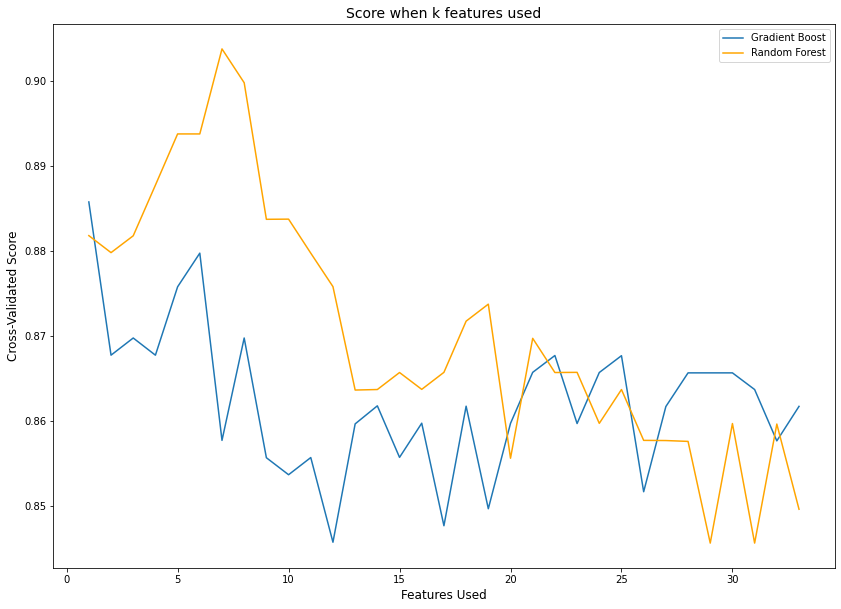

In [47]:
plt.figure(figsize=(14,10))
sns.lineplot(x=k, y=score, label='Gradient Boost')
sns.lineplot(x=k_r, y=score_r, color='orange', label='Random Forest')
plt.xlabel('Features Used', fontsize=12)
plt.ylabel('Cross-Validated Score', fontsize=12)
plt.title('Score when k features used', fontsize=14)
plt.legend();

In [48]:
select_features = SelectKBest(score_func=mutual_info_classif, k=1)
select_features.fit(X_train_new_scaled, y_train_new)
X_reduced = select_features.transform(X_train_new_scaled)
X_test_reduced = select_features.transform(X_test_new_scaled)
gradient = GradientBoostingClassifier(random_state=42)
cross_val_score(gradient, X_reduced, y_train_new, cv=5).mean()

0.8857575757575757

In [49]:
select_features_r = SelectKBest(score_func=mutual_info_classif, k=7)
select_features_r.fit(X_train_new_scaled, y_train_new)
X_reduced_r = select_features_r.transform(X_train_new_scaled)
X_test_reduced_r = select_features_r.transform(X_test_new_scaled)
random = RandomForestClassifier(random_state=42)
cross_val_score(random, X_reduced_r, y_train_new, cv=5).mean()

0.9037575757575758

In [50]:
grad = GradientBoostingClassifier(random_state=42).fit(X_reduced, y_train)

In [51]:
pred = grad.predict(X_test_reduced)

In [52]:
random.fit(X_reduced_r, y_train)
pred_r = random.predict(X_test_reduced_r)

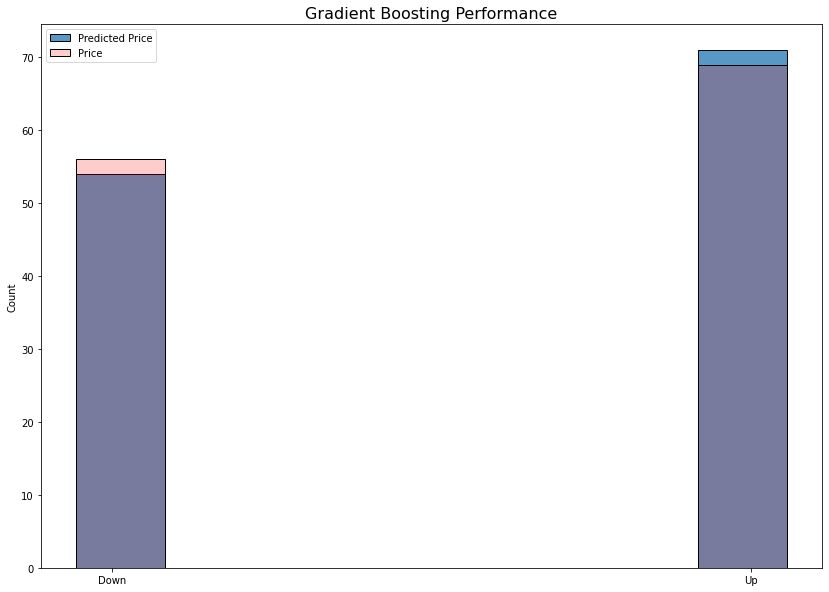

In [53]:
plt.figure(figsize=(14,10))
sns.histplot(pred, label='Predicted Price')
sns.histplot(y_test, color='r', alpha=0.2, label='Price')
plt.xticks(ticks=[0.05, 0.95], labels=['Down', 'Up'])
plt.xlabel('')
plt.title('Gradient Boosting Performance',
         fontsize=16);
plt.legend();

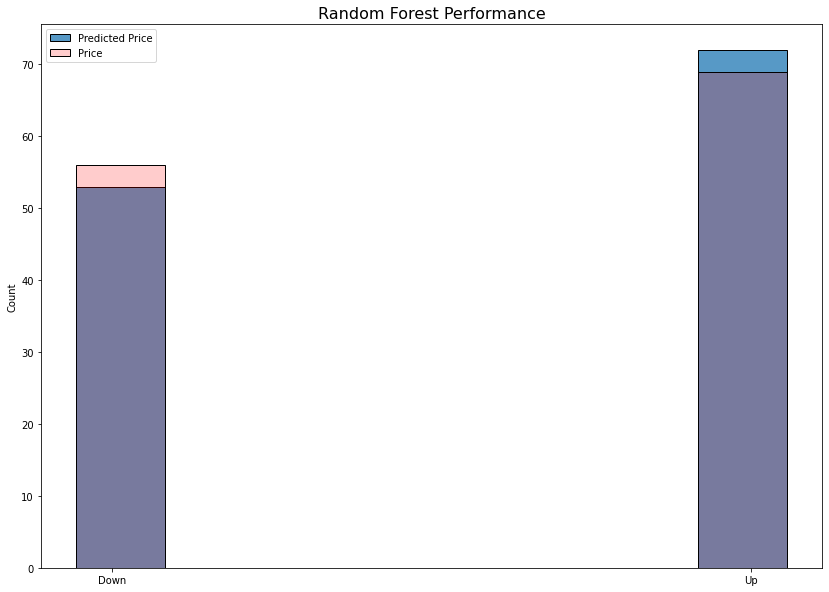

In [54]:
plt.figure(figsize=(14,10))
sns.histplot(pred_r, label='Predicted Price')
sns.histplot(y_test, color='r', alpha=0.2, label='Price')
plt.xticks(ticks=[0.05, 0.95], labels=['Down', 'Up'])
plt.xlabel('')
plt.title('Random Forest Performance',
         fontsize=16);
plt.legend();

> We can see that our model has a tendency to over-choose 1 (price will go up)

In [55]:
classifiers_reduced = Utils().find_best_features_gradient(X_train_new_scaled, y_train_new)